# Training a Fully Connected Neural Network using Tensorflow

In [1]:
import os
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'2.6.0'

## Loading Training Data

Currently, the data we have is unbalanced and future updates should improve on this.

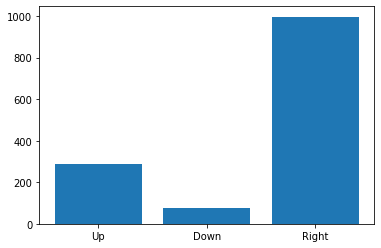

In [3]:
parent_dir = os.getcwd()
training_data_folder = os.path.join(parent_dir, "training_data")

up_folder = os.path.join(training_data_folder, "up")
down_folder = os.path.join(training_data_folder, "down")
right_folder = os.path.join(training_data_folder, "right")

up_images = os.listdir(up_folder)
down_images = os.listdir(down_folder)
right_images = os.listdir(right_folder)

up_count = len(up_images)
down_count = len(down_images)
right_count = len(right_images)

labels = ["Up","Down","Right"]
plt.bar(labels,[up_count, down_count, right_count])
plt.show()

## Preparing the Images for Training

Input Array Shape: (1358, 2400)
Label Array Shape: (1358,)


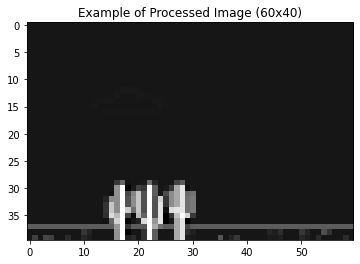

In [4]:
X = []
y = []

folder_list = [up_folder, down_folder, right_folder]

for curr_folder in folder_list:
    for image_name in os.listdir(curr_folder):
        label = image_name[:image_name.index("(")]

        image = cv.imread(os.path.join(curr_folder, image_name))
        grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        normalized = grayscale / 255
        resized = cv.resize(normalized, (60, 40), interpolation=cv.INTER_AREA)

        # Unrolling the matrices into vectors of 2400 pixels.
        X.append(np.ravel(resized))
        y.append(label)

X = np.array(X)
y = np.array(y)

plt.imshow(np.reshape(X[0], (40,60)), cmap="gray")
plt.title("Example of Processed Image (60x40)")

print("Input Array Shape:",X.shape)
print("Label Array Shape:",y.shape)

## Encoding the Categorical Labels (up, down and right) to One-Hot-Encoded

In [5]:
encoder = OneHotEncoder(categories=[["up", "down", "right"]])
y_encoded = np.array(encoder.fit_transform(y.reshape(-1,1)).toarray())

print(y_encoded[:5, :])
print(y_encoded.shape)


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(1358, 3)


## Splitting the Dataset into Training and Test Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=True)

## Configuring the Network

In [7]:
model = tf.keras.models.Sequential()

# Hidden Layer
model.add(tf.keras.layers.Dense(units=100, input_shape=(2400,), activation="relu"))
# 3 output units, one for each of the possible keys to press.
model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               240100    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 240,403
Trainable params: 240,403
Non-trainable params: 0
_________________________________________________________________


## Compile and Train

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 3ms/step - loss: 1.0177 - accuracy: 0.6915
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 0.8444 - accuracy: 0.7394
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.7763 - accuracy: 0.7293
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.7449
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.7523
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.7532
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.7661
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.7762
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.7762
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 0.5935 - accuracy: 0.7808
Epoch 11/

## Model Evaluation

In [9]:
y_pred = np.round(model.predict(X_test))
print(np.mean(y_test == y_pred) * 100)

89.2156862745098


## Exporting the Model

In [10]:
if "saved_model" not in os.listdir(parent_dir):
    os.mkdir(os.path.join(parent_dir, "saved_model"))

model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets
